# Image caption generator

## Part 1 - seq2seq auto encoder

In [1]:
from fastai.text import *
import pandas as pd
from pathlib import Path
from PIL import Image

In [2]:
gpu = torch.device('cuda:0')

In [3]:
PATH = Path('data/')
PATH.mkdir(exist_ok=True)

In [4]:
seq_PATH = PATH/'seq2deq_model'
seq_PATH.mkdir(exist_ok=True)

In [5]:
path = Path('~/scratch/suchith_data/data/')
df = pd.read_csv(path/"Train_text.tsv", sep="\t",header=None)

In [6]:
N = df.shape[0]
valid_pc = 0.2

num_valid = int(N*valid_pc)
rand_idx = np.random.permutation(N)
valid_idx = rand_idx[:num_valid]
train_idx = rand_idx[num_valid:]

In [7]:
captions_and_links_valid = df.iloc[valid_idx]
captions_and_links_train = df.iloc[train_idx]

In [8]:
len(captions_and_links_valid), len(captions_and_links_train)

(10000, 40000)

In [9]:
captions_and_links_valid.head()

,0,1
45517,train_data/res45518.jpg,a bunch of people take pictures
8680,train_data/res8681.jpg,a person stands next to
42433,train_data/res42434.jpg,a kid does a trick
19997,train_data/res19998.jpg,two rugby teams are on the field
14304,train_data/res14305.jpg,a little girl wearing an orange halloween shirt


In [10]:
captions_valid = captions_and_links_valid[1].values
captions_train = captions_and_links_train[1].values

In [11]:
len(captions_train), len(captions_valid)

(40000, 10000)

### Tokenization

In [12]:
tokenizer = Tokenizer()

In [13]:
captions_valid

array(['a bunch of people take pictures', 'a person stands next to', 'a kid does a trick',
       'two rugby teams are on the field', ..., 'a woman dressed up in', 'a kid blocks a goal during a soccer',
       'a lady in black victoria l', 'two dogs run in the'], dtype=object)

In [14]:
tokens_captions_valid = tokenizer.process_all(captions_valid)

In [15]:
tokens_captions_train = tokenizer.process_all(captions_train)

**Let's make sure everything went right:**

In [16]:
print(captions_train[777], ' '.join(tokens_captions_train[777]))

two women wearing ballerina attire are two women wearing ballerina attire are


### Length of captions
#### Average length of captions

In [17]:
np.mean([len(c) for c in tokens_captions_valid])

5.834

In [18]:
np.mean([len(c) for c in tokens_captions_train])

5.822075

#### Discard captions that are too long

In [19]:
tokens_captions_valid = np.array(tokens_captions_valid)[np.array([len(c) < 30 for c in tokens_captions_valid])]

/scratch/cse/phd/anz198717/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


In [20]:
np.max([len(c) for c in tokens_captions_valid])

15

In [21]:
tokens_captions_train = np.array(tokens_captions_train)[np.array([len(c) < 30 for c in tokens_captions_train])]

/scratch/cse/phd/anz198717/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


In [22]:
np.max([len(c) for c in tokens_captions_train])

12

In [23]:
pickle.dump((tokens_captions_valid), (seq_PATH/'tok_cap_v.pkl').open('wb'))

In [24]:
pickle.dump((tokens_captions_train), (seq_PATH/'tok_cap_t.pkl').open('wb'))

In [25]:
tokens_captions_valid = pickle.load((seq_PATH/'tok_cap_v.pkl').open('rb'))

In [26]:
tokens_captions_train = pickle.load((seq_PATH/'tok_cap_t.pkl').open('rb'))

In [27]:
print(len(tokens_captions_train), len(tokens_captions_valid))

40000 10000


### Numericalization

In [28]:
vocab = Vocab.create(tokens_captions_train, max_vocab=50000, min_freq=2)

In [29]:
pickle.dump(vocab, open(PATH/"vocab.pkl", 'wb'))

In [30]:
vocab = pickle.load((PATH/"vocab.pkl").open('rb'))

**Let's quickly test this:**

In [31]:
idx = 1000

In [32]:
test_caption = tokens_captions_valid[idx]
print(' '.join(w for w in test_caption))

three teenagers standing around a building


In [33]:
test_caption_num = vocab.numericalize(test_caption)
print(test_caption_num)

[35, 429, 38, 89, 9, 232]


In [34]:
print(vocab.textify(test_caption_num))

three teenagers standing around a building


In [35]:
tokens_captions_valid[0]

['a', 'bunch', 'of', 'people', 'take', 'pictures']

In [36]:
def numericalize_tokens(tok):
    return np.array([vocab.numericalize(q) + [1] for q in tok])

In [37]:
captions_numericalized_valid = numericalize_tokens(tokens_captions_valid)

/scratch/cse/phd/anz198717/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [38]:
captions_numericalized_train = numericalize_tokens(tokens_captions_train)

/scratch/cse/phd/anz198717/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Test it:

In [39]:
vocab.textify(captions_numericalized_train[10000])

'three people walking on a snow covered xxpad'

### Word vectors

In [40]:
#! pip install git+https://github.com/facebookresearch/fastText.git

In [41]:
import fasttext as ft

In [42]:
en_vecs = ft.load_model(str(seq_PATH/'wiki.en.bin'))

In [43]:
vec_dict = {w : en_vecs.get_word_vector(w) for w in en_vecs.get_words()}

In [44]:
pickle.dump(vec_dict, open(seq_PATH/'vec_dict.pkl', 'wb'))

In [45]:
vec_dict = pickle.load(open(seq_PATH/'vec_dict.pkl','rb'))

**Let's take a look at the most frequent words from fastText:**

In [46]:
ft_words = en_vecs.get_words(include_freq=True)

In [47]:
ft_word_dict = {k:v for k,v in zip(*ft_words)}

In [48]:
ft_words = sorted(ft_word_dict.keys(), key=lambda x: ft_word_dict[x])

10 most frequent words:

In [49]:
ft_words[-10:]

[')', "'", 'and', 'in', '-', 'of', '</s>', 'the', '.', ',']

**Mean and stdv of the word vectors:**

In [50]:
vecs = np.stack(list(vec_dict.values()))

In [51]:
vecs.mean(), vecs.std()

(0.0075652334, 0.29283327)

### Dataset

In [52]:
def A(*a):
    """convert iterable object into numpy array"""
    return np.array(a[0]) if len(a)==1 else [np.array(o) for o in a]

In [53]:
class Caption2CaptionDataset(Dataset):
    def __init__(self, x):
        self.x = x
    def __getitem__(self, idx):
        return A(self.x[idx], self.x[idx])
    def __len__(self):
        return len(self.x)

In [54]:
trn_ds = Caption2CaptionDataset(captions_numericalized_train)

In [55]:
val_ds = Caption2CaptionDataset(captions_numericalized_valid)

In [56]:
len(trn_ds), len(val_ds)

(40000, 10000)

In [57]:
vocab.textify(trn_ds[0][0])

'three children and an adult xxpad'

In [58]:
####
trn_ds_subset = Caption2CaptionDataset(captions_numericalized_train[:100000])

In [59]:
####
len(trn_ds_subset)

40000

### Dataloader

In [60]:
bs = 125

In [61]:
val_sampler = SortSampler(captions_numericalized_valid, key=lambda x:len(captions_numericalized_valid[x]))

trn_sampler = SortishSampler(captions_numericalized_train, key=lambda x: len(captions_numericalized_train[x]), bs=bs)

In [62]:
####
trn_sampler = SortishSampler(captions_numericalized_train[:100000], key=lambda x: len(captions_numericalized_train[x]), bs=bs)

Since we want to fully utilize the GPUs capabilities, we train in batches. The length of a minibatch tensor is set by the sequence length of the longest question in that batch. The other questions are padded. To save time and memory, we want to avoid very long and very short questions in one batch because that would mean lot's of padding. For the validation set we simply sort the questions. For training we use the `SortishSampler` which groups *longer* questions together and *shorter* questions together while preserving some randomness.

For language models it's better to pad before the start of the sequence because we need the final hidden state to predict the next token or for classification...

For sequence to sequence models it is better to pad after the end of the sequence.

The samplers return an index:

In [63]:
i = next(iter(trn_sampler))

In [64]:
vocab.textify(captions_numericalized_train[i])

'several stall - shops selling various goods line a dimly - lit xxpad'

In [65]:
import pdb

In [66]:
def pad_collate_seq2seq(samples:BatchSamples, pad_idx:int=1, pad_first:bool=True, backwards:bool=False, transpose:bool=False) -> Tuple[LongTensor, LongTensor]:
    "Function that collect samples and adds padding. Flips token order if needed"
    samples = to_data(samples)
    max_len_inp = max([len(s[0]) for s in samples])
    max_len_out = max([len(s[1]) for s in samples])
    
    res_inp = torch.zeros(len(samples), max_len_inp).long() + pad_idx
    res_out = torch.zeros(len(samples), max_len_out).long() + pad_idx
    
    if backwards: pad_first = not pad_first
    for i,s in enumerate(samples):
        if pad_first: 
            res_inp[i,-len(s[0]):] = LongTensor(s[0])
            res_out[i,-len(s[1]):] = LongTensor(s[1])
        else:         
            res_inp[i,:len(s[0]):] = LongTensor(s[0])  # TK
            res_out[i,:len(s[1]):] = LongTensor(s[1])
    if backwards:
        res = res.flip(1)
    if transpose:
        res_inp.transpose_(0,1)
        res_out.transpose_(0,1)
    return res_inp, res_out

In [67]:
my_pad_collate_func = partial(pad_collate_seq2seq, pad_first=False, transpose=True)

In [68]:
trn_dl = DataLoader(dataset=trn_ds, batch_size=bs, sampler=trn_sampler, collate_fn=my_pad_collate_func)

In [69]:
val_dl = DataLoader(dataset=val_ds, batch_size=bs, sampler=val_sampler, collate_fn=my_pad_collate_func)

In [70]:
####
trn_dl = DataLoader(dataset=trn_ds_subset, batch_size=bs, sampler=trn_sampler, collate_fn=my_pad_collate_func)

Let's test the dataloader:

In [71]:
it = iter(val_dl)

In [72]:
its = [next(it) for _ in range(3)]

In [73]:
[(x.shape, y.shape) for x, y in its]

[(torch.Size([16, 125]), torch.Size([16, 125])),
 (torch.Size([9, 125]), torch.Size([9, 125])),
 (torch.Size([9, 125]), torch.Size([9, 125]))]

In [74]:
for x, y in its:
    print(vocab.textify(x[:,100]))
    print(vocab.textify(y[:,100]))
    print()

a boy in a blue shirt is doing xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad
a boy in a blue shirt is doing xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad

a woman with short blond - hair xxunk xxpad
a woman with short blond - hair xxunk xxpad

two boys in blue shirts fighting in a xxpad
two boys in blue shirts fighting in a xxpad



### Model

In [75]:
n_hid, n_layers = 400, 3

In [76]:
def create_emb(wordvecs, itos, emb_sz):
    emb= nn.Embedding(len(itos), emb_sz, padding_idx=1)
    weights = emb.weight.data
    not_found = []
    
    for idx, word in enumerate(itos):
        try:
            weights[idx] = torch.from_numpy(wordvecs[word] * 3)
        except:
            not_found.append(word)
    print(len(not_found), not_found[5:10])
    return emb

In [77]:
class seq2seqAutoEncoder(nn.Module):
    def __init__(self, device, wordvecs, itos, emb_sz, n_hid, out_seqlen, n_layers=2):
        super().__init__()
        self.n_hid, self.n_layers, self.out_seqlen = n_hid, n_layers, out_seqlen
        self.device = device
        
        # Encoder
        self.emb = create_emb(wordvecs, itos, emb_sz)
        self.emb = self.emb.to(self.device)
        self.emb_drop = nn.Dropout(0.15)
        self.rnn_enc = nn.GRU(emb_sz, n_hid, num_layers=n_layers, dropout=0.25)
        self.output_enc = nn.Linear(n_hid, emb_sz, bias=False)
        
        # Decoder
        self.rnn_dec = nn.GRU(emb_sz, emb_sz, num_layers=n_layers, dropout=0.1)  # square to enable weight tying
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(emb_sz, len(itos))
        self.out.weight.data = self.emb.weight.data
        
    def forward(self, inp):
        #pdb.set_trace()
        _, h = self.encode(inp)
        
        dec_inp = torch.zeros(inp.size(1), requires_grad=False).long()
        dec_inp = dec_inp.to(self.device)
        res = []
        
        for i in range(self.out_seqlen):
            dec_output, h = self.decode(dec_inp, h)
            res.append(dec_output)
            dec_inp = dec_output.data.max(1)[1]  # [1] to get argmax
            if (dec_inp == 1).all():
                break
        
        return torch.stack(res)
    
    def encode(self, inp):
        h = self.initHidden(inp.size(1))  # bs
        h = h.to(self.device)
        emb = self.emb_drop(self.emb(inp))
        enc_output, h = self.rnn_enc(emb, h) # h[1] is same as enc_outp[-1]!
        
        h = self.output_enc(h)
        
        return enc_output, h
    
    def decode(self, dec_inp, h):
        emb_inp = self.emb(dec_inp).unsqueeze(0)  # adds unit axis at beginning so that rnn 'loops' once
        output, h = self.rnn_dec(emb_inp, h)
        output = self.out(self.out_drop(output[0]))

        return F.log_softmax(output, dim=1), h
    
    def initHidden(self, bs):
        return torch.zeros(self.n_layers, bs, self.n_hid, requires_grad=False)

In [78]:
def Seq2SeqLoss(pred, target):
    seqlen, bs = target.size()
    seqlen_pred, bs_pred, n_probs = pred.size()
    
    # we need to pad if target seqlen is larger than prediction seqlen
    if seqlen > seqlen_pred:
        pred = F.pad(pred, (0,0,0,0,0,seqlen-seqlen_pred))
    
    # but we only compare until the seqlen of the target
    pred = pred[:seqlen]
    
    # cross_entropy can't handle rank 3 tensors currently, we need to flatten
    return F.nll_loss(pred.contiguous().view(-1, n_probs), target.contiguous().view(-1))

In [79]:
emb_sz = vec_dict["cat"].size
emb_sz

300

In [80]:
rnn = seq2seqAutoEncoder(gpu, vec_dict, vocab.itos, emb_sz, n_hid, 30, n_layers)
rnn = rnn.to(gpu)

42 ['xxmaj', 'xxup', 'xxrep', 'xxwrep', "'s"]


In [81]:
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))  # like bind in c++

In [82]:
dataBunch = DataBunch(train_dl=trn_dl, valid_dl=val_dl, device=gpu, path=seq_PATH, collate_fn=my_pad_collate_func)

In [83]:
learn = Learner(data=dataBunch, model=to_device(rnn, gpu), opt_func=opt_fn, loss_func=Seq2SeqLoss, callback_fns=ShowGraph)

In [92]:
learn.lr_find()

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [88]:
learn.recorder.plot(skip_end=15)

In [94]:
lr = 1e-3

epoch,train_loss,valid_loss,time
0,3.665082,2.734751,00:39
1,1.462116,1.971083,00:19
2,0.744303,0.759689,00:20
3,0.536784,0.204527,00:16
4,0.265448,0.154832,00:16
5,0.241645,0.085390,00:14
6,0.121705,0.051542,00:16
7,0.066160,0.031022,00:13
8,0.047213,0.026487,00:14
9,0.039327,0.025108,00:17


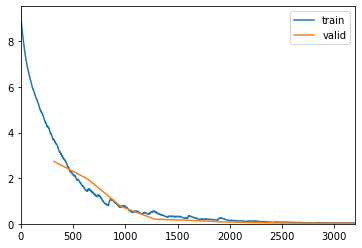

In [95]:
learn.fit_one_cycle(10, lr)

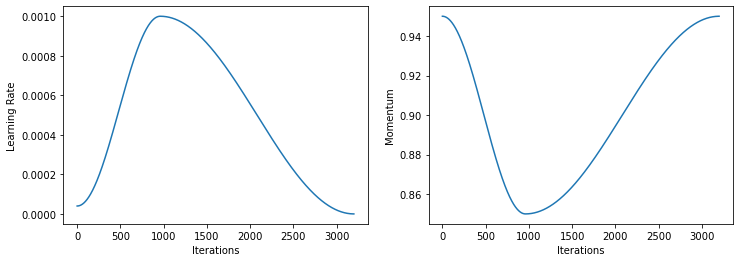

In [96]:
learn.recorder.plot_lr(show_moms=True)

In [99]:
#learn.save("GRU_try1")

In [ ]:
learn.load("GRU_try1")

In [101]:
learn.model.state_dict().keys()

odict_keys(['emb.weight', 'rnn_enc.weight_ih_l0', 'rnn_enc.weight_hh_l0', 'rnn_enc.bias_ih_l0', 'rnn_enc.bias_hh_l0', 'rnn_enc.weight_ih_l1', 'rnn_enc.weight_hh_l1', 'rnn_enc.bias_ih_l1', 'rnn_enc.bias_hh_l1', 'rnn_enc.weight_ih_l2', 'rnn_enc.weight_hh_l2', 'rnn_enc.bias_ih_l2', 'rnn_enc.bias_hh_l2', 'output_enc.weight', 'rnn_dec.weight_ih_l0', 'rnn_dec.weight_hh_l0', 'rnn_dec.bias_ih_l0', 'rnn_dec.bias_hh_l0', 'rnn_dec.weight_ih_l1', 'rnn_dec.weight_hh_l1', 'rnn_dec.bias_ih_l1', 'rnn_dec.bias_hh_l1', 'rnn_dec.weight_ih_l2', 'rnn_dec.weight_hh_l2', 'rnn_dec.bias_ih_l2', 'rnn_dec.bias_hh_l2', 'out.weight', 'out.bias'])

In [102]:
torch.save(learn.model.state_dict(), PATH/"seq2seqAutoencoderStateDict.pth")

In [103]:
list(learn.model.rnn_dec.parameters())[0]

Parameter containing:
tensor([[-0.0603, -0.0359, -0.0235,  ...,  0.0347,  0.0137,  0.0411],
        [-0.0617, -0.0107, -0.0096,  ..., -0.0028, -0.0202,  0.0379],
        [ 0.1328,  0.0255, -0.0462,  ...,  0.0353, -0.0409,  0.0134],
        ...,
        [ 0.0509, -0.0507,  0.0228,  ...,  0.0141, -0.0303,  0.0252],
        [ 0.0253, -0.0222,  0.0521,  ...,  0.0274, -0.0173,  0.0243],
        [-0.0252,  0.0243,  0.0615,  ...,  0.0193, -0.0501, -0.0295]],
       device='cuda:0', requires_grad=True)

In [104]:
list(learn.model.rnn_dec.parameters())[0]

Parameter containing:
tensor([[-0.0603, -0.0359, -0.0235,  ...,  0.0347,  0.0137,  0.0411],
        [-0.0617, -0.0107, -0.0096,  ..., -0.0028, -0.0202,  0.0379],
        [ 0.1328,  0.0255, -0.0462,  ...,  0.0353, -0.0409,  0.0134],
        ...,
        [ 0.0509, -0.0507,  0.0228,  ...,  0.0141, -0.0303,  0.0252],
        [ 0.0253, -0.0222,  0.0521,  ...,  0.0274, -0.0173,  0.0243],
        [-0.0252,  0.0243,  0.0615,  ...,  0.0193, -0.0501, -0.0295]],
       device='cuda:0', requires_grad=True)

### Let's try the model

In [105]:
learn.model.train()

seq2seqAutoEncoder(
  (emb): Embedding(4096, 300, padding_idx=1)
  (emb_drop): Dropout(p=0.15, inplace=False)
  (rnn_enc): GRU(300, 400, num_layers=3, dropout=0.25)
  (output_enc): Linear(in_features=400, out_features=300, bias=False)
  (rnn_dec): GRU(300, 300, num_layers=3, dropout=0.1)
  (out_drop): Dropout(p=0.35, inplace=False)
  (out): Linear(in_features=300, out_features=4096, bias=True)
)

In [106]:
learn.model.eval()

seq2seqAutoEncoder(
  (emb): Embedding(4096, 300, padding_idx=1)
  (emb_drop): Dropout(p=0.15, inplace=False)
  (rnn_enc): GRU(300, 400, num_layers=3, dropout=0.25)
  (output_enc): Linear(in_features=400, out_features=300, bias=False)
  (rnn_dec): GRU(300, 300, num_layers=3, dropout=0.1)
  (out_drop): Dropout(p=0.35, inplace=False)
  (out): Linear(in_features=300, out_features=4096, bias=True)
)

## Beamsearch

Watch this [video](https://www.youtube.com/watch?v=RLWuzLLSIgw) (and the following two in the series) for a good explanation.

The original beam-search strategy finds a translation
that approximately maximizes the conditional
probability given by a specific model. It builds
the translation from left-to-right and keeps a fixed
number (beam) of translation candidates with the
highest log-probability at each time step. For each
end-of-sequence symbol that is selected among
the highest scoring candidates the beam is reduced
by one and the translation is stored into a final candidate
list. When the beam is zero, it stops the
search and picks the translation with the highest
log-probability (normalized by the number of target
words) out of the final candidate list.

[Source](https://www.aclweb.org/anthology/W17-3207)

In [87]:
class HypothesisNode():
    """ Hypothesis Node class for performing Beam Search """
    def __init__(self, sequence, log_prob, hidden_state):
        """HypothesisNode constructur
        
        Args:
          sequence: A sequence of tokens
          log_prob: The log of the probability of this sequence
          hidden_state: The hidden state of the Decoder RNN after decoding the last token in the sequence
        """
        self._seq = sequence
        self._log_prob = log_prob
        self._h = hidden_state
    
    @property
    def last_tok(self):
        """
        Returns:
          The last token in the sequence
        """
        return self._seq[-1]
        
    def update(self, tok, log_prob, new_h):
        """
        Updates the sequence with a new token and returns a new Hypothesis Node
        Args:
          tok: The new token that is appended to the sequence
          log_prob: The log of the probability ot this token
          new_h: The new hidden state of the Decoder RNN after this token
        
        Returns:
          An Hypothesis Node with the updated sequence, log probability and hidden state
        """
        return HypothesisNode(self._seq + [tok], self._log_prob + log_prob, new_h)
    
    def __str__(self):
        return ('Hyp(log_p = %4f,\t seq = %s)' % (self._log_prob, vocab.textify([t.item()for t in self._seq])))

In [85]:
class BeamSearch():
    """ Performs BeamSearch for seq2seq decoding or Image captioning """
    def __init__(self, enc_model, dec_model, beam_width, max_len):
        """BeamSearch object constructor
        Args:
          enc_model: A seq2seq encoder or cnn for image captioning
          dec_model: A RNN decoder model
          beam_width: int, the number of hypotheses to remember in each iteration
          max_len: int, the longest possible sequence
        """
        self._enc_model = enc_model
        self._dec_model = dec_model
        self._beam_width = beam_width
        self._max_len = max_len
        self._start_tok = 0
        self._end_tok   = 1
        
    def search(self, inp_seq, verbose=False):
        """Performs the Beam search
        Args:
          inp_seq: the input sequence to be encoded
          verbose: bool, allows printing the intermediate hypotheses for better understanding
        
        Returns:
          The 'beam_width' most probable sentences
        """
        inp_seq = torch.tensor(inp_seq).unsqueeze(0).transpose_(0,1).cuda()
        _, h = self._enc_model(inp_seq)

        hyps = [HypothesisNode([torch.zeros(1, requires_grad=False).long().cuda()], 0, h)]
        results = []
        
        step = 0
        width = self._beam_width
        while width > 0 and step < self._max_len:
            if verbose: print("\n Step: ",step)
            new_hyps = []
            for h in hyps:
                new_hyps.extend(self.get_next_hypotheses(h, width))
            
            new_hyps = sorted(new_hyps, key= lambda x: x._log_prob, reverse=True)
            if verbose: self.print_hypotheses(new_hyps, "Before narrowing:")
                
            hyps = []
            for h in new_hyps[:width]:
                if h.last_tok == self._end_tok:
                    results.append(h)
                    width = width - 1
                else:
                    hyps.append(h)
            
            if verbose: 
                self.print_hypotheses(hyps, "After narrowing:")
                self.print_hypotheses(results, "Results:")
                
            step += 1
         
        results.extend(hyps[:width])
        results = sorted(results, key=lambda x: x._log_prob/len(x._seq), reverse=True)
        
        if verbose: self.print_hypotheses(results, "Final:")
        
        return [[t.item() for t in r._seq[1:]] for r in results]
        
    def get_next_hypotheses(self, hyp, k):
        """Calculates the next 'beam_width' hypotheses given a Hypothesis Node
        Args:
          hyp: an Hypothesis Node containing a sequence, a log probability and a Decoder RNN hidden state
          k: the number of hypotheses to calculate
        Returns:
          A list with the 'beam_width' most probable sequences/Hypothesis Nodes
        """

        dec_outp, h = self._dec_model(hyp.last_tok, hyp._h)

        top_k_log_probs, top_k_toks = dec_outp.topk(k, dim=1)
        
        return [hyp.update(top_k_toks[0][i].unsqueeze(0), top_k_log_probs[0][i], h) for i in range(k)]
    
    def print_hypotheses(self, hyps, description):
        print(description)
        for h in hyps:
            print(h)

In [ ]:
BeamSearcher = BeamSearch(learn.model.encode, learn.model.decode, 5, 30)

In [ ]:
def show_random_val_prediction(idx:int):
    print(idx)
    data = learn.data.valid_ds[idx][0]
    results = BeamSearcher.search(data, True)

    print("\nlabel\t",vocab.textify(data))
    data = torch.tensor(data).unsqueeze(0).transpose_(0,1).cuda()
    res = learn.model((data))
    res = res.data.max(2)[1]
    res = res.transpose_(0,1).data.cpu().numpy()
    print("greedy\t",vocab.textify(res[0]))

    print("beam\t",vocab.textify(results[0]))
    #return (vocab.textify(data),vocab.textify(res[0]) ,vocab.textify(results[0]))

In [ ]:
show_random_val_prediction(1000)

## Part 2 - Image caption generator
### Image caption dataset

In [201]:
IMAGE_PATH = Path("/home/cse/phd/anz198717/scratch/suchith_data/data/")

In [210]:
def show_training_pair(PATH, df, idx):
    fn, caption = df.iloc[idx]
    img = np.array(Image.open(PATH/fn))
    img = np.where(img > 230, 255, 0)
    img = Image.fromarray(np.uint8(img))
    plt.imshow(img)
    print(caption)

#### Examples from the validation dataset:

three teenagers standing around a building


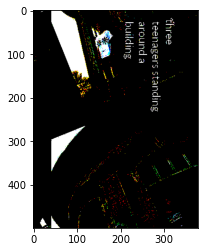

In [211]:
show_training_pair(IMAGE_PATH, captions_and_links_valid, 1000)

a woman tastes a watermelon


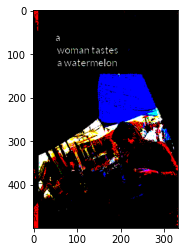

In [212]:
show_training_pair(IMAGE_PATH, captions_and_links_valid, 500)

#### Examples from the train dataset:

two women are in a


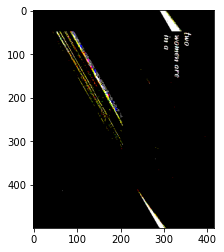

In [213]:
show_training_pair(IMAGE_PATH, captions_and_links_train, 4000)

three woman are sitting in front of


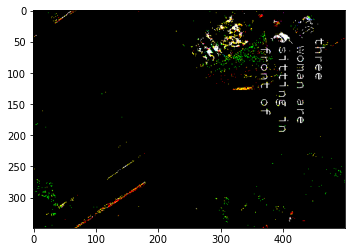

In [214]:
show_training_pair(IMAGE_PATH, captions_and_links_train, 3000)

#### Construct a subset of the  training set for experimentation (the full dataset is ~600GB)

In [101]:
from shutil import copyfile

In [102]:
def create_subset(sz):
    #subset_indxs = random.sample(range(0, len(train_dict_full)), sz)
    subset_indxs = [key for key in train_dict_full if len(train_dict_full[key][1]) < 25]
    subset_dict = dict()
    for idx in subset_indxs:
        if idx in train_dict_full:
            copyfile(TRAIN_PATH_FULL/"downloadedPics"/"{}.png".format(idx), TRAIN_PATH_SUBSET/"downloadedPics"/"{}.png".format(idx))
            subset_dict[idx] = train_dict_full[idx]
    pickle.dump(subset_dict, open(TRAIN_PATH_SUBSET/'caption_dict.pkl', 'wb'))

In [104]:
#create_subset(100000)

In [87]:
train_dict_subset = pickle.load((TRAIN_PATH_SUBSET/"caption_dict.pkl").open('rb'))

### Define custom Dataset class and collate_fn

In [105]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import ImageFile
import pdb
ImageFile.LOAD_TRUNCATED_IMAGES = True

The last line is crucial as some of the images have too large metadata and PIL throws the Exception `ValueError: Decompressed Data Too Large` (see [here](https://stackoverflow.com/questions/42671252/python-pillow-valueerror-decompressed-data-too-large)).

In [106]:
vocab = pickle.load((PATH/"vocab.pkl").open('rb'))

In [107]:
def build_data(captions_dict, PATH, is_valid=False):
    filenames, captions = zip(*captions_dict.values)
    filenames = list(map(lambda x: str(PATH) +"/" + x,filenames))
    captions = tokenizer.process_all(captions)
    captions_tok = numericalize_tokens(captions)
    dataset = (filenames, captions_tok)
    return dataset

In [108]:
train_data = build_data(captions_and_links_train, IMAGE_PATH)
valid_data = build_data(captions_and_links_valid, IMAGE_PATH)

/scratch/cse/phd/anz198717/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [215]:
class ImageCaptionDataset(Dataset):
    def __init__(self, data, transform=None):
        """
        Args:
          data (tuple): Contains a list of filenames and a list of tokenized and numericalized captions
          transforms (callable, optional): Optional transforms to be applied
        """
        self.filenames = data[0]
        self.captions  = data[1]
        self.transform = transform
    
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, idx):
        # There are grayscale images in dataset and tensor shapes have to match except in dim=0
        image = np.array(Image.open(self.filenames[idx]))
        image = np.where(image > 230, 255, 0)
        image = Image.fromarray(np.uint8(image))
        caption = self.captions[idx]
        
        if self.transform is not None:
            image = self.transform(image)
        
        return (image, caption)

In [216]:
def pad_collate_ImgCap(samples:BatchSamples, pad_idx:int=1, pad_first:bool=True, backwards:bool=False, transpose:bool=False) -> Tuple[LongTensor, LongTensor]:
    "Function that collect samples and adds padding. Flips token order if needed"
    images, captions = zip(*samples)
    max_len_cap = max([len(c) for c in captions])
    
    res_cap = torch.zeros(len(samples), max_len_cap).long() + pad_idx
    
    if backwards: pad_first = not pad_first
    for i,c in enumerate(captions):
        if pad_first: 
            res_cap[i,-len(c):] = LongTensor(c)
        else:         
            res_cap[i,:len(c)] = LongTensor(c)
    
    if backwards:
        cap = cap.flip(1)
    if transpose:
        res_cap.transpose_(0,1)
    
    return (torch.stack(images, 0, out=None), res_cap), res_cap

In [217]:
imgcap_collate_func = partial(pad_collate_ImgCap, pad_first=False, transpose=True)

#### Get mean and stdv

Taken from [here](https://discuss.pytorch.org/t/about-normalization-using-pre-trained-vgg16-networks/23560/9).

In [218]:
tfms = transforms.Compose([
    #transforms.CenterCrop(300),
    transforms.ToTensor()
])

In [219]:
train_dataset_subset = ImageCaptionDataset(train_data, transform=tfms)

In [220]:
len(train_dataset_subset)

40000

In [221]:
loader = DataLoader(train_dataset_subset, batch_size=56, num_workers=1, shuffle=False, collate_fn=imgcap_collate_func)

In [197]:
def online_mean_and_sd(loader):
    """Compute the mean and sd in an online fashion

        Var[x] = E[X^2] - E^2[X]
    """
    cnt = 0
    fst_moment = torch.empty(3)
    snd_moment = torch.empty(3)

    for idx,data in enumerate(loader):
        data = data[0][0]
        b, c, h, w = data.shape
        nb_pixels = b * h * w
        sum_ = torch.sum(data, dim=[0, 2, 3])
        sum_of_square = torch.sum(data ** 2, dim=[0, 2, 3])
        fst_moment = (cnt * fst_moment + sum_) / (cnt + nb_pixels)
        snd_moment = (cnt * snd_moment + sum_of_square) / (cnt + nb_pixels)

        cnt += nb_pixels
        if idx % 100 == 0:
            print(idx/(len(train_dataset_subset)/56))

    return fst_moment, torch.sqrt(snd_moment - fst_moment ** 2)

In [181]:
mean, std = online_mean_and_sd(loader)

0.0
0.13999999999999999
0.27999999999999997
0.42
0.5599999999999999
0.7
0.84
0.98


In [155]:
mean, std = tensor([0.5238, 0.5003, 0.4718]), tensor([0.3159, 0.3091, 0.3216])

### Build the datasets

In [156]:
sz = 224

In [222]:
tfms = transforms.Compose([
    transforms.Resize((sz, sz)),
    #transforms.RandomRotation(10, expand=False),
    #transforms.CenterCrop(sz),
    #transforms.RandomCrop(224),
    #transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.5238, 0.5003, 0.4718],[0.3159, 0.3091, 0.3216])
])

In [223]:
inv_normalize = transforms.Normalize(
    mean=[-0.5238/0.3159, -0.5003/0.3091, -0.4718/0.3216],
    std=[1/0.3159, 1/0.3091, 1/0.3216]
)

In [224]:
denorm = transforms.Compose([
    inv_normalize,
    transforms.functional.to_pil_image
])

In [225]:
valid_dataset = ImageCaptionDataset(valid_data, transform=tfms)

In [226]:
train_dataset = ImageCaptionDataset(train_data, transform=tfms)

In [227]:
#train_dataset_full = ImageCaptionDataset(train_data_full, transform=tfms)

In [228]:
print(
    "Valid dataset: {}\nTrain dataset: {}".format(len(valid_dataset), len(train_dataset))
)

Valid dataset: 10000
Train dataset: 40000


**Quick test:**

two males playing soccer with the male xxpad


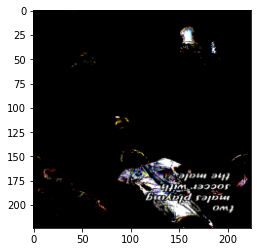

In [229]:
idx = 100
d = train_dataset
img, cap = d[idx]
print(vocab.textify(cap))
plt.imshow(denorm(img))

### Build the dataloaders

In [230]:
bs = 80

In [231]:
val_sampler = SortSampler(valid_data[1], key=lambda x:len(valid_data[1][x]))
trn_sampler = SortishSampler(train_data[1], key=lambda x: len(train_data[1][x]), bs=bs)

In [232]:
val_dl = DataLoader(dataset=valid_dataset, batch_size=bs, sampler=val_sampler, collate_fn=imgcap_collate_func)
trn_dl = DataLoader(dataset=train_dataset, batch_size=bs, sampler=trn_sampler, collate_fn=imgcap_collate_func)

In [233]:
ims, caps = next(iter(trn_dl))

several asian women dressed up in cosplay outfits xxpad xxpad xxpad xxpad xxpad


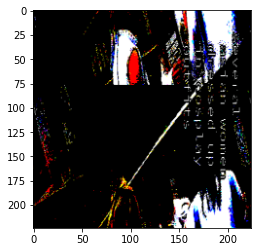

In [234]:
idx = 66

print(vocab.textify(caps[:,idx]))
plt.imshow(denorm(ims[0][idx]))

### Build the first model

In [235]:
from torchvision import models

In [236]:
vec_dict = pickle.load(open(seq_PATH/'vec_dict.pkl','rb'))

In [237]:
n_hid, n_layers = 400, 3
emb_sz = 300

In [238]:
def MLP(n_in, n_out, p=0.2):
    return nn.Sequential(
        Flatten(),
        #nn.BatchNorm1d(n_in),
        #nn.Dropout(p),
        nn.Linear(in_features=n_in, out_features=n_in, bias=True),
        nn.ReLU(),
        nn.Linear(in_features=n_in, out_features=n_in, bias=True),
        nn.ReLU(),
        #nn.Linear(in_features=2048, out_features=2048, bias=True),
        #nn.ReLU(),
        #nn.BatchNorm1d(n_in),
        #nn.Dropout(p),
        nn.Linear(in_features=n_in, out_features=n_out, bias=True)
    )

In [239]:
class Encoder(nn.Module):
    def __init__(self, device, dec_hidden_state_size, dec_layers, filter_width, num_filters):
        super().__init__()
        # Visual Encoder
        self.device = device
        self.base_network = nn.Sequential(*list(models.resnet101(pretrained=True).children())[:-2])
        self.freeze_base_network()
        self.concatPool = AdaptiveConcatPool2d(sz=1)
        self.adaptivePool = nn.AdaptiveAvgPool2d((filter_width, filter_width))
        self.filter_width = filter_width
        
        self.output_layers = nn.ModuleList([
            MLP(2*num_filters, dec_hidden_state_size) for _ in range(dec_layers)
        ])
        
        
    def forward(self, inp):
        #pdb.set_trace()
        enc_output = self.base_network(inp)
        annotation_vecs = self.adaptivePool(enc_output).view(enc_output.size(0), enc_output.size(1), -1)
        enc_output = self.concatPool(enc_output)
        
        dec_init_hidden_states = [MLP_layer(enc_output) for MLP_layer in self.output_layers]
        
        return torch.stack(dec_init_hidden_states, dim = 0), annotation_vecs.transpose(1, 2)
    
    def freeze_base_network(self):
        for layer in self.base_network:
            requires_grad(layer, False)
            
    def fine_tune(self, from_block=-1):
        for layer in self.base_network[from_block:]:
            requires_grad(layer, True)

In [240]:
class VisualAttention(nn.Module):
    def __init__(self, num_filters, dec_dim, att_dim):
        super().__init__()
        self.attend_annot_vec = nn.Linear(num_filters, att_dim)
        self.attend_dec_hidden= nn.Linear(dec_dim, att_dim)
        self.f_att = nn.Linear(att_dim, 1)  # Equation (4) in Xu et al. (2015)
        
    def forward(self, annotation_vecs, dec_hid_state):
        #pdb.set_trace()
        attended_annotation_vecs = self.attend_annot_vec(annotation_vecs)
        attended_dec_hid_state   = self.attend_dec_hidden(dec_hid_state)
        e = self.f_att(F.relu(attended_annotation_vecs + attended_dec_hid_state.unsqueeze(1))).squeeze(2)  # Eq. 4
        alphas = F.softmax(e, dim=1)  # Equation (5) in Xu et al. (2015)
        context_vec = (annotation_vecs * alphas.unsqueeze(2)).sum(1)  # Equations (13)
        
        return context_vec, alphas

In [241]:
class ImageCaptionGenerator(nn.Module):
    def __init__(self, device, filter_width, num_filters, wordvecs, itos, emb_sz, out_seqlen, n_layers=3, prob_teach_forcing=1):
        super().__init__()
        self.n_layers, self.out_seqlen = n_layers, out_seqlen
        self.filter_width = filter_width
        self.num_filters = num_filters
        self.device = device  
        
        # Encoder
        self.encoder = Encoder(device, emb_sz, n_layers, filter_width, num_filters)
        self.annotation_vecs = None
        
        # Attention
        self.att = VisualAttention(num_filters, emb_sz, 500)
        
        # Decoder
        self.emb = create_emb(wordvecs, itos, emb_sz)
        self.rnn_dec = nn.GRU(num_filters + emb_sz, emb_sz, num_layers=n_layers, dropout=0.)  # 0.1 square to enable weight tying
        self.out_drop = nn.Dropout(0.)#0.35)
        self.out = nn.Linear(emb_sz, len(itos))
        self.out.weight.data = self.emb.weight.data
        self.f_b = nn.Linear(emb_sz, num_filters)  # Section 4.2.1 in Xu et al. (2015)
        
        self.prob_teach_forcing = prob_teach_forcing
       
    def forward(self, x, y=None):
        #pdb.set_trace()
        h, self.annotation_vecs = self.encoder(x.to(self.device))
        pixels_per_channel = self.annotation_vecs.size(1)

        dec_inp = torch.zeros(h.size(1), requires_grad=False).long()
        dec_inp = dec_inp.to(self.device)
        res = []
        alphas = []
        
        for i in range(self.out_seqlen):
            #pdb.set_trace()
            dec_output, h, alpha = self.decode_step(dec_inp, h)
            res.append(dec_output)
            alphas.append(alpha)
            dec_inp = dec_output.data.max(1)[1]  # [1] to get argmax
            if (dec_inp == 1).all():
                break
            
            # teacher forcing
            if self.training and (self.prob_teach_forcing > 0) and (random.random() < self.prob_teach_forcing):
                if i >= len(y):
                    break  # nothing to whisper
                dec_inp = y[i].to(self.device)
                
        return torch.stack(res), torch.stack(alphas)
    
    def decode_step(self, dec_inp, h):
        #pdb.set_trace()
        context_vec, alpha = self.att(self.annotation_vecs, h[-1])
        beta = torch.sigmoid(self.f_b(h[-1]))
        context_vec = beta * context_vec  # Section 4.2.1 in Xu et al. (2015)
        
        emb_inp = self.emb(dec_inp).unsqueeze(0)  # adds unit axis at beginning so that rnn 'loops' once

        output, h = self.rnn_dec(torch.cat([emb_inp, context_vec.unsqueeze(0)], dim=2), h)
        output = self.out(self.out_drop(output[0]))

        return F.log_softmax(output, dim=1), h, alpha

In [242]:
@dataclass
class TeacherForcingCallback(Callback):
    def __init__(self, learn:Learner):
        super().__init__()
        self.learn = learn
    
    def on_epoch_begin(self, epoch: int, **kwargs: Any) -> None:
        self.learn.model.prob_teach_forcing = (30-epoch) * 1/30 if epoch < 30 else 0

In [243]:
def ImageCaptionLoss(pred, target, lamb = 1):
    pred, alphas = pred
    seqlen, bs = target.size()
    seqlen_pred, bs_pred, n_probs = pred.size()
    
    # we need to pad if target seqlen is larger than prediction seqlen
    if seqlen > seqlen_pred:
        pred = F.pad(pred, (0,0,0,0,0,seqlen-seqlen_pred))
    
    # but we only compare until the seqlen of the target
    pred = pred[:seqlen]
    
    # cross_entropy can't handle rank 3 tensors currently, we need to flatten
    loss = F.nll_loss(pred.contiguous().view(-1, n_probs), target.contiguous().view(-1))
    
    # See section 4.2.1 "Doubly stocastic attention"
    penalty = ((1. - alphas.sum(0)) ** 2.).mean()
    # ((1. - alphas.sum(0)) ** 2.).sum(1).mean()

    return loss + lamb * penalty

In [244]:
imgCapGen = ImageCaptionGenerator(gpu, 14, 2048, vec_dict, vocab.itos, emb_sz, 30, n_layers)

42 ['xxmaj', 'xxup', 'xxrep', 'xxwrep', "'s"]


In [245]:
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))  # like bind in c++

In [246]:
dataBunch = DataBunch(train_dl=trn_dl, valid_dl=val_dl, device=gpu, path=PATH, collate_fn=imgcap_collate_func)

In [247]:
learn = Learner(data=dataBunch, model=to_device(imgCapGen, gpu), opt_func=opt_fn, loss_func=ImageCaptionLoss, callback_fns=[ShowGraph, TeacherForcingCallback]) # , BnFreeze 

In [248]:
learn.lr_find()

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


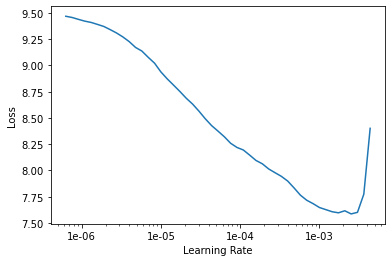

In [249]:
learn.recorder.plot(skip_end=6)

In [250]:
lr = 1e-4

epoch,train_loss,valid_loss,time
0,4.702609,5.449034,45:01


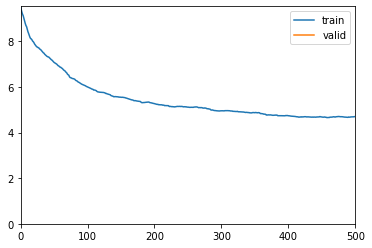

In [251]:
learn.fit_one_cycle(1, lr)

In [163]:
#learn.save("long_1")

In [306]:
learn.save("captionGenerator_att")

In [262]:
learn.load("captionGenerator_att")

Learner(data=DataBunch;

Train: <__main__.ImageCaptionDataset object at 0x2b47c9a39050>;

Valid: <__main__.ImageCaptionDataset object at 0x2b47c1e34310>;

Test: None, model=ImageCaptionGenerator(
  (encoder): Encoder(
    (base_network): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, 

In [263]:
learn.model.eval()

ImageCaptionGenerator(
  (encoder): Encoder(
    (base_network): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inpla

In [252]:
#from scipy.misc import imresize
from scipy.ndimage.filters import gaussian_filter

In [253]:
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt, verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

def  draw_outline(matplt_plot_obj, lw):
    matplt_plot_obj.set_path_effects([patheffects.Stroke(linewidth=lw, foreground='black'), patheffects.Normal()])

def show_img(im, figsize=None, ax=None, alpha=1, cmap=None):
    if not ax:
        fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha, cmap=cmap)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

In [274]:
learn.model.encode

AttributeError: 'ImageCaptionGenerator' object has no attribute 'encode'

In [ ]:
BeamSearcher = BeamSearch(learn.model.encode, learn.model.decode, 5, 30)
def show_random_val_prediction(idx:int):
    print(idx)
    data = learn.data.valid_ds[idx][0]
    results = BeamSearcher.search(data, True)

    print("\nlabel\t",vocab.textify(data))
    data = torch.tensor(data).unsqueeze(0).transpose_(0,1).cuda()
    res = learn.model((data))
    res = res.data.max(2)[1]
    res = res.transpose_(0,1).data.cpu().numpy()
    print("greedy\t",vocab.textify(res[0]))

    print("beam\t",vocab.textify(results[0]))
    #return (vocab.textify(data),vocab.textify(res[0]) ,vocab.textify(results[0]))

2229 tensor([[[ -6.1112, -21.1812, -27.9694,  ..., -22.3460, -29.5390, -12.3508]],

        [[ -5.0952, -18.0855, -20.7866,  ..., -20.4834, -19.7018, -11.1618]],

        [[ -4.7074, -12.3728, -16.9205,  ..., -16.7280, -14.5415,  -8.8465]],

        ...,

        [[ -4.4805,  -4.8034, -11.8995,  ..., -10.6801, -13.1645,  -9.9193]],

        [[ -4.6310,  -2.1057,  -8.5211,  ...,  -8.0169, -12.0382,  -9.7049]],

        [[ -4.9434,  -0.4799,  -6.4617,  ...,  -6.4972, -11.5340,  -9.2844]]],
       device='cuda:0', grad_fn=<StackBackward>)
a black and brown dog xxpad


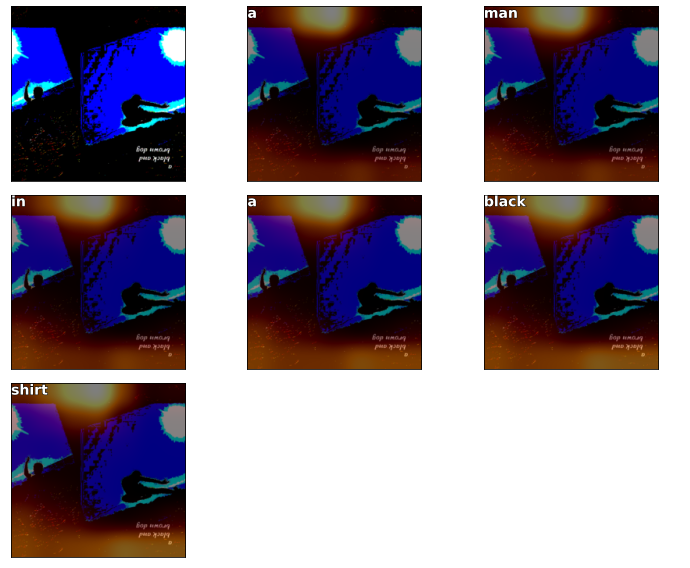

In [280]:
idx = random.randint(0, len(learn.data.train_ds))
im = learn.data.train_ds[idx][0]
pred, alphas = learn.model(im.unsqueeze(0).to(gpu))
print(idx, pred)
pred = pred.data.max(2)[1]
pred = pred.transpose_(0,1).data.cpu().numpy()
pred = pred[0]
alphas = alphas.view(-1,1,  14, 14).cpu().data.numpy()
alphas = np.maximum(0, alphas)
alphas -= alphas.min()
alphas /= alphas.max()
cap_len = pred.size

figure, axes = plt.subplots(cap_len//3 + 1,3, figsize=(10,8))
for i, ax in enumerate(axes.flat):
    if i < cap_len:
        ax = show_img(denorm(im), ax=ax)
        if i > 0:
            mask = np.array(Image.fromarray(alphas[i - 1,0]).resize((sz,sz)))
            blurred_mask = gaussian_filter(mask, sigma=10)
            show_img(blurred_mask, ax=ax, alpha=0.5, cmap='afmhot')
            draw_text(ax, (0,0), vocab.itos[pred[i - 1]])
    else:
        ax.axis('off')
plt.tight_layout()

print(vocab.textify(learn.data.train_ds[idx][1]))